In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nilaymenon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nilaymenon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.
Plot your data. For tabular data, you will need to run scatters, for image data, you will need to plot your example classes.
How will you preprocess your data? You should explain this in your readme.md file and link your jupyter notebook to it. Your jupyter notebook should be uploaded to your repo.
Jupyter Notebook data download and environment setup requirements: 


In [46]:
df = pd.read_csv('Glassdoor_Job_Postings.csv')
df.head(5)

,company,job_title,company_rating,job_description,location,salary_avg_estimate,salary_estimate_payperiod,company_size,company_founded,employment_type,industry,sector,revenue,career_opportunities_rating,comp_and_benefits_rating,culture_and_values_rating,senior_management_rating,work_life_balance_rating
0,ABB,Junior Data Analyst,4.0,Junior Data Analyst\nTake your next career ste...,Bengaluru,"₹3,25,236",/yr (est.),10000+ Employees,1883,Company - Public,Electronics Manufacturing,Manufacturing,$10+ billion (USD),3.7,3.6,4.0,3.5,3.9
1,Philips,Data Scientist - AI/ML,4.0,Job Title\nData Scientist - AI/ML\nJob Descrip...,Bengaluru,NaN,NaN,10000+ Employees,1891,Company - Public,Healthcare Services & Hospitals,Healthcare,$10+ billion (USD),3.8,3.7,4.0,3.5,4.0
2,HSBC,Data Science GSC’s,3.9,Job description\nGraduate/ Post-graduate degre...,Bengaluru,NaN,NaN,10000+ Employees,1865,Company - Public,Banking & Lending,Finance,$10+ billion (USD),3.6,3.6,3.8,3.4,3.7
3,Facctum Solutions,Data Analyst,NaN,Job Description\nExperience: 0 - 2 years in da...,Karnataka,NaN,NaN,1 to 50 Employees,--,Company - Private,--,--,Unknown / Non-Applicable,NaN,NaN,NaN,NaN,NaN
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.0,JOB DESCRIPTION\n\nYou are a strategic thinker...,India,NaN,NaN,10000+ Employees,1799,Company - Public,Banking & Lending,Finance,$10+ billion (USD),4.0,3.9,3.9,3.6,3.7


## Data Preprocessing

In [47]:
# Convert company_founded to int
df['company_founded'] = df['company_founded'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)

In [48]:
# Convert salary_avg_estimate to float
df['salary_avg_estimate'] = df['salary_avg_estimate'].apply(lambda x: float(str(x).replace('₹', '').replace(',', '')) if pd.notna(x) else np.nan)

In [49]:
# Convert job_description to list
df['job_description'] = df['job_description'].apply(lambda x: x.split('\n') if pd.notna(x) else x)

### Data Imputation


In [50]:
## company column: inpute "unknown"

df['company'] = df['company'].fillna('Unknown')



## imputting ratings for company related ratings
df['career_opportunities_rating'] = df['career_opportunities_rating'].fillna(df['career_opportunities_rating'].mean())
df['comp_and_benefits_rating'] = df['comp_and_benefits_rating'].fillna(df['comp_and_benefits_rating'].mean())
df['culture_and_values_rating'] = df['culture_and_values_rating'].fillna(df['culture_and_values_rating'].mean())
df['senior_management_rating'] = df['senior_management_rating'].fillna(df['senior_management_rating'].mean())
df['work_life_balance_rating'] = df['work_life_balance_rating'].fillna(df['work_life_balance_rating'].mean())


## company rating: 
columns_to_average = ['career_opportunities_rating',
'comp_and_benefits_rating',       
'culture_and_values_rating',      
'senior_management_rating',       
'work_life_balance_rating']

average_values = df[columns_to_average].mean(axis = 1)


df['company_rating'] = df['company_rating'].fillna(average_values)

## dropping job description nan

df.dropna(subset = ['job_description'],inplace = True)

## imputting salary_avg_estimate

# Perform KNN imputation
columns_to_drop = ['company', 'job_title', 'job_description', 'location', 'salary_estimate_payperiod',
                   'company_size', 'company_founded', 'employment_type', 'industry', 'sector', 'revenue']

data_for_imputation = df.drop(columns=columns_to_drop)

data_for_imputation = pd.get_dummies(data_for_imputation)

imputer = KNNImputer()

imputed_data = imputer.fit_transform(data_for_imputation)

df['salary_avg_estimate'] = imputed_data[:, data_for_imputation.columns.get_loc('salary_avg_estimate')]

## getting most frequent pay period and imputing missing values

df['salary_estimate_payperiod'] = df['salary_estimate_payperiod'].fillna(df['salary_estimate_payperiod'].mode()[0])



## company size imputtation 
df['company_size'] = df['company_size'].fillna('Unknown')


## company founded imputtation 

df['company_founded'] = df['company_founded'].fillna(0000.0)

## imputing employment_type, industry,sector,revenue

df['employment_type'] = df['employment_type'].fillna('Unknown')
df['industry'] = df['industry'].fillna('Unknown')
df['industry'] = df['industry'].replace('--','Unknown')

df['revenue'] = df['revenue'].fillna('Unknown')

df['sector'] = df['sector'].fillna('Unknown')
df['sector'] = df['sector'].replace('--','Unknown')

In [51]:
# Create salary_avg_per_year

# Convert salary_estimate_payperiod to factors 

factors = {'/yr (est.)': 1,
          '/mo (est.)': 12,
          '/hr (est.)': 2123}

df['salary_estimate_payperiod'] = df['salary_estimate_payperiod'].apply(lambda x: factors[x] if (type(x) == str) else x)

# Multiply 'salary_avg_estimate' by 'salary_estimate_payperiod'
df['salary_avg_estimate'] = df['salary_avg_estimate'] * df['salary_estimate_payperiod']

# Rename the column to 'salary_avg_estimate_per_year'
df = df.rename(columns={'salary_avg_estimate': 'salary_avg_estimate_per_year'})
df.drop(columns = 'salary_estimate_payperiod')

,company,job_title,company_rating,job_description,location,salary_avg_estimate_per_year,company_size,company_founded,employment_type,industry,sector,revenue,career_opportunities_rating,comp_and_benefits_rating,culture_and_values_rating,senior_management_rating,work_life_balance_rating
0,ABB,Junior Data Analyst,4.000000,"[Junior Data Analyst, Take your next career st...",Bengaluru,325236.0,10000+ Employees,1883.0,Company - Public,Electronics Manufacturing,Manufacturing,$10+ billion (USD),3.700000,3.600000,4.00000,3.500000,3.900000
1,Philips,Data Scientist - AI/ML,4.000000,"[Job Title, Data Scientist - AI/ML, Job Descri...",Bengaluru,657767.6,10000+ Employees,1891.0,Company - Public,Healthcare Services & Hospitals,Healthcare,$10+ billion (USD),3.800000,3.700000,4.00000,3.500000,4.000000
2,HSBC,Data Science GSC’s,3.900000,"[Job description, Graduate/ Post-graduate degr...",Bengaluru,615428.4,10000+ Employees,1865.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),3.600000,3.600000,3.80000,3.400000,3.700000
3,Facctum Solutions,Data Analyst,3.780438,"[Job Description, Experience: 0 - 2 years in d...",Karnataka,534300.0,1 to 50 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,3.838304,3.678796,3.90301,3.677702,3.804378
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.000000,"[JOB DESCRIPTION, , You are a strategic thinke...",India,574184.4,10000+ Employees,1799.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),4.000000,3.900000,3.90000,3.600000,3.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,Kpro Solutions,Analytics & Data Science,4.000000,"[Experience & Qualification:, , Minimum of 9 y...",Bengaluru,483915.0,1 to 50 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,4.000000,4.000000,4.00000,4.000000,4.000000
896,Athena Global Technologies,Data Engineer,3.900000,"[Immediate requirement for Data Engineer, Expe...",Hyderābād,678949.0,51 to 200 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,4.200000,3.500000,4.00000,3.900000,3.900000
897,Wesco,India-Bangalore: Data Engineer,3.700000,[This person will work independently or with a...,Bengaluru,651920.0,10000+ Employees,1922.0,Company - Public,Wholesale,Retail & Wholesale,$10+ billion (USD),3.500000,3.400000,3.60000,3.300000,3.800000
898,Course5,Data Scientist,4.200000,[If you meet our position requirements and can...,Bengaluru,424426.0,1001 to 5000 Employees,2000.0,Company - Private,Business Consulting,Management & Consulting,$100 to $500 million (USD),4.300000,4.100000,4.30000,4.100000,4.200000


In [52]:
df

,company,job_title,company_rating,job_description,location,salary_avg_estimate_per_year,salary_estimate_payperiod,company_size,company_founded,employment_type,industry,sector,revenue,career_opportunities_rating,comp_and_benefits_rating,culture_and_values_rating,senior_management_rating,work_life_balance_rating
0,ABB,Junior Data Analyst,4.000000,"[Junior Data Analyst, Take your next career st...",Bengaluru,325236.0,1,10000+ Employees,1883.0,Company - Public,Electronics Manufacturing,Manufacturing,$10+ billion (USD),3.700000,3.600000,4.00000,3.500000,3.900000
1,Philips,Data Scientist - AI/ML,4.000000,"[Job Title, Data Scientist - AI/ML, Job Descri...",Bengaluru,657767.6,1,10000+ Employees,1891.0,Company - Public,Healthcare Services & Hospitals,Healthcare,$10+ billion (USD),3.800000,3.700000,4.00000,3.500000,4.000000
2,HSBC,Data Science GSC’s,3.900000,"[Job description, Graduate/ Post-graduate degr...",Bengaluru,615428.4,1,10000+ Employees,1865.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),3.600000,3.600000,3.80000,3.400000,3.700000
3,Facctum Solutions,Data Analyst,3.780438,"[Job Description, Experience: 0 - 2 years in d...",Karnataka,534300.0,1,1 to 50 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,3.838304,3.678796,3.90301,3.677702,3.804378
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.000000,"[JOB DESCRIPTION, , You are a strategic thinke...",India,574184.4,1,10000+ Employees,1799.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),4.000000,3.900000,3.90000,3.600000,3.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,Kpro Solutions,Analytics & Data Science,4.000000,"[Experience & Qualification:, , Minimum of 9 y...",Bengaluru,483915.0,1,1 to 50 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,4.000000,4.000000,4.00000,4.000000,4.000000
896,Athena Global Technologies,Data Engineer,3.900000,"[Immediate requirement for Data Engineer, Expe...",Hyderābād,678949.0,1,51 to 200 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,4.200000,3.500000,4.00000,3.900000,3.900000
897,Wesco,India-Bangalore: Data Engineer,3.700000,[This person will work independently or with a...,Bengaluru,651920.0,1,10000+ Employees,1922.0,Company - Public,Wholesale,Retail & Wholesale,$10+ billion (USD),3.500000,3.400000,3.60000,3.300000,3.800000
898,Course5,Data Scientist,4.200000,[If you meet our position requirements and can...,Bengaluru,424426.0,1,1001 to 5000 Employees,2000.0,Company - Private,Business Consulting,Management & Consulting,$100 to $500 million (USD),4.300000,4.100000,4.30000,4.100000,4.200000


In [53]:
#one hot encode company size
one_hot_encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
encoded_data = one_hot_encoder.fit_transform(df[['company_size']])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(['company_size']))

# Concatenate with the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

#one hot encode revenue

# Fit and transform the data
encoded_data = one_hot_encoder.fit_transform(df[['revenue']])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(['revenue']))

# Concatenate with the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

#one hot encode sector
one_hot_encoder = OneHotEncoder(sparse=False)

encoded_data = one_hot_encoder.fit_transform(df[['sector']])

encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(['sector']))

df = pd.concat([df, encoded_df], axis=1)

df.head(5)

/Users/nilaymenon/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/nilaymenon/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/nilaymenon/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,company,job_title,company_rating,job_description,location,salary_avg_estimate_per_year,salary_estimate_payperiod,company_size,company_founded,employment_type,...,sector_Manufacturing,sector_Media & Communication,sector_Non-profit & NGO,sector_Pharmaceutical & Biotechnology,sector_Real Estate,sector_Retail & Wholesale,sector_Telecommunications,sector_Transportation & Logistics,sector_Unknown,sector_nan
0,ABB,Junior Data Analyst,4.000000,"[Junior Data Analyst, Take your next career st...",Bengaluru,325236.0,1.0,10000+ Employees,1883.0,Company - Public,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Philips,Data Scientist - AI/ML,4.000000,"[Job Title, Data Scientist - AI/ML, Job Descri...",Bengaluru,657767.6,1.0,10000+ Employees,1891.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HSBC,Data Science GSC’s,3.900000,"[Job description, Graduate/ Post-graduate degr...",Bengaluru,615428.4,1.0,10000+ Employees,1865.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Facctum Solutions,Data Analyst,3.780438,"[Job Description, Experience: 0 - 2 years in d...",Karnataka,534300.0,1.0,1 to 50 Employees,0.0,Company - Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.000000,"[JOB DESCRIPTION, , You are a strategic thinke...",India,574184.4,1.0,10000+ Employees,1799.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Concatenate text
def tokenize(job_description):
    def is_iterable(obj):
        try:
            iter(obj)
            return True
        except TypeError:
            return False
        if not is_iterable(job_description):
            return None

# Check if job_description is not iterable or is empty
    if not is_iterable(job_description) or len(job_description) == 0:
        return None

    text = ''.join(job_description)

    # Lowercase conversion
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)

    # Removing punctuation and special characters
    tokens = [re.sub(r'[^a-zA-Z0-9\s]', '', token) for token in tokens if token.isalnum()]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Feature extraction (optional)
    # This can involve extracting skills, qualifications, responsibilities, etc. based on patterns in the text.
    return tokens

df['job_description'] = df['job_description'].apply(tokenize)
df.dropna(subset=['job_description'], inplace=True)
df['job_description'] = df['job_description'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'job_description' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['job_description'])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame for visualization (optional)
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

df = pd.concat([df, df_tfidf], axis=1)

# Print the concatenated DataFrame
numeric_columns = [col for col in df.columns if re.match(r'^\d', col)]
df = df.drop(columns=numeric_columns)

In [55]:
df

,company,job_title,company_rating,job_description,location,salary_avg_estimate_per_year,salary_estimate_payperiod,company_size,company_founded,employment_type,...,zonesexcellent,zonesgood,zoneswilling,zookeeper,zoom,zoominfo,zs,zsers,zycus,zydus
0,ABB,Junior Data Analyst,4.000000,junior data analysttake next career step abb g...,Bengaluru,325236.0,1.0,10000+ Employees,1883.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Philips,Data Scientist - AI/ML,4.000000,job titledata scientist descriptionjob title d...,Bengaluru,657767.6,1.0,10000+ Employees,1891.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HSBC,Data Science GSC’s,3.900000,job degree relevant field data science certifi...,Bengaluru,615428.4,1.0,10000+ Employees,1865.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Facctum Solutions,Data Analyst,3.780438,job descriptionexperience 0 2 years data opera...,Karnataka,534300.0,1.0,1 to 50 Employees,0.0,Company - Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.000000,job descriptionyou strategic thinker passionat...,India,574184.4,1.0,10000+ Employees,1799.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Exploration

## Plots

TypeError: 'value' must be an instance of str or bytes, not a float

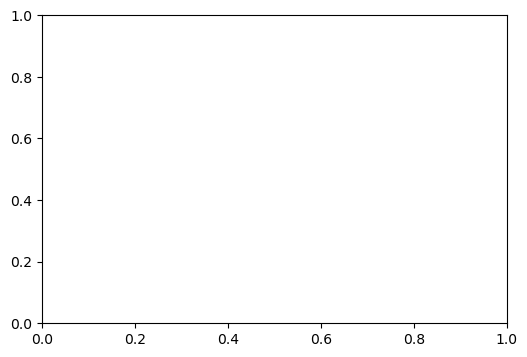

In [24]:
plt.figure(figsize=(6, 4))
plt.hist(df['company_founded'], bins=20, edgecolor='black')
plt.xlabel('Year Founded')
plt.ylabel('Frequency')
plt.title('Distribution of Company Founded Years')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [25]:
df['avg_rating'] = (df['career_opportunities_rating']+df['comp_and_benefits_rating']+ df['culture_and_values_rating']+df['senior_management_rating']+ df['work_life_balance_rating'])/5
df['avg_rating']

0      3.740000
1      3.800000
2      3.620000
3      3.780438
4      3.820000
         ...   
675         NaN
773         NaN
810         NaN
811         NaN
861         NaN
Name: avg_rating, Length: 900, dtype: float64

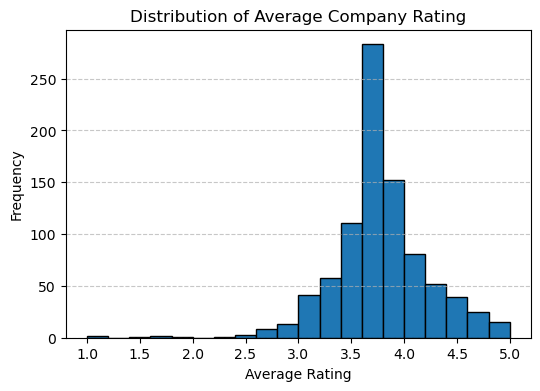

In [26]:
plt.figure(figsize=(6, 4))
plt.hist(df['avg_rating'], bins=20, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Company Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

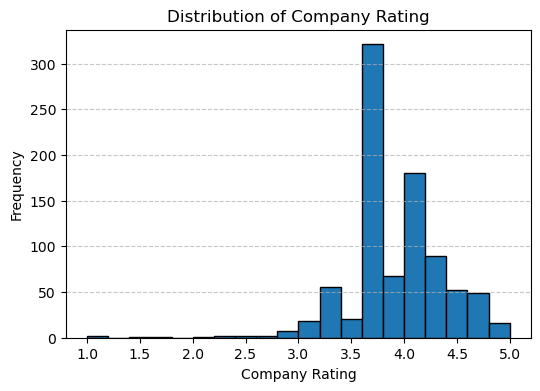

In [27]:
plt.figure(figsize=(6, 4))
plt.hist(df['company_rating'], bins=20, edgecolor='black')
plt.xlabel('Company Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Company Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

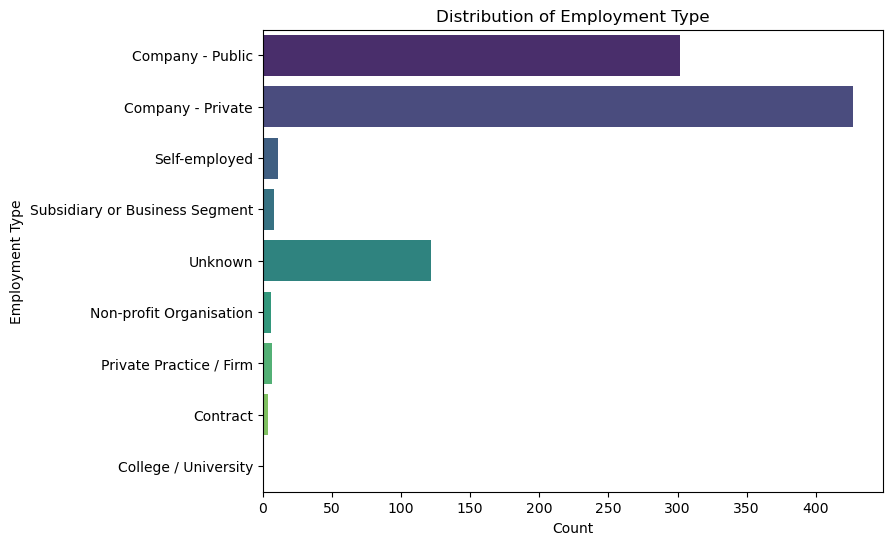

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(y='employment_type', data=df, palette='viridis')
plt.title('Distribution of Employment Type')
plt.xlabel('Count')
plt.ylabel('Employment Type')
plt.show()

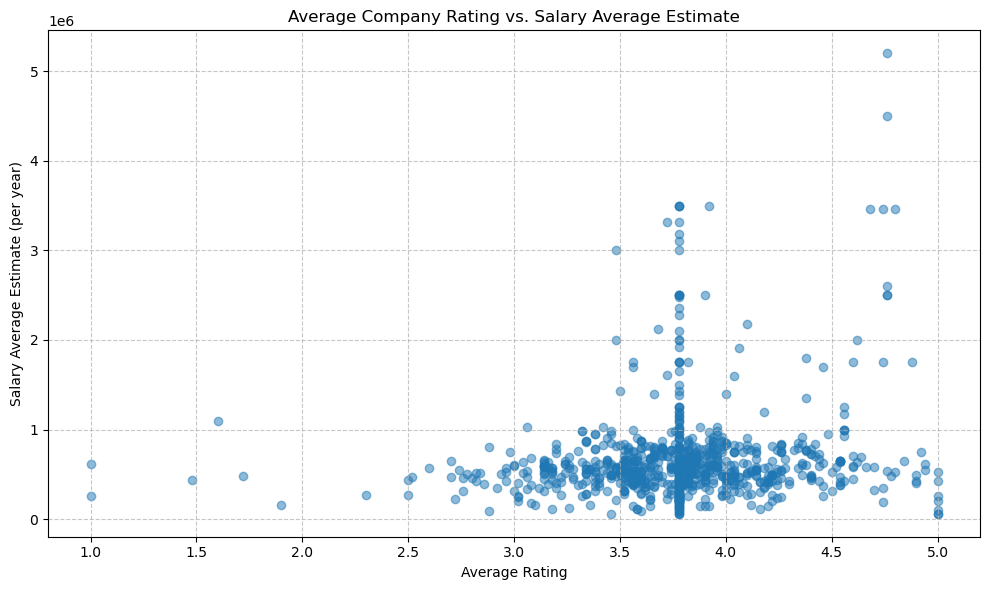

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(df['avg_rating'], df['salary_avg_estimate_per_year'], alpha=0.5)
plt.xlabel('Average Rating')
plt.ylabel('Salary Average Estimate (per year)')
plt.title('Average Company Rating vs. Salary Average Estimate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
# sector_columns = [col for col in df.columns if col.startswith('sector_')]
# data = df[['salary_avg_estimate_per_year'] + sector_columns]

# melted_data = data.melt(id_vars='salary_avg_estimate_per_year', var_name='Sector', value_name='Sector_Encoded')
# melted_data = melted_data[melted_data['Sector_Encoded'] == 1]

# plt.figure(figsize=(12, 8))
# sns.boxplot(x='salary_avg_estimate_per_year', y='Sector', data=melted_data, palette='viridis')
# plt.xlabel('Salary Average Estimate (per year)')
# plt.ylabel('Sector')
# plt.title('Salary Distribution Across Different Sectors')
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

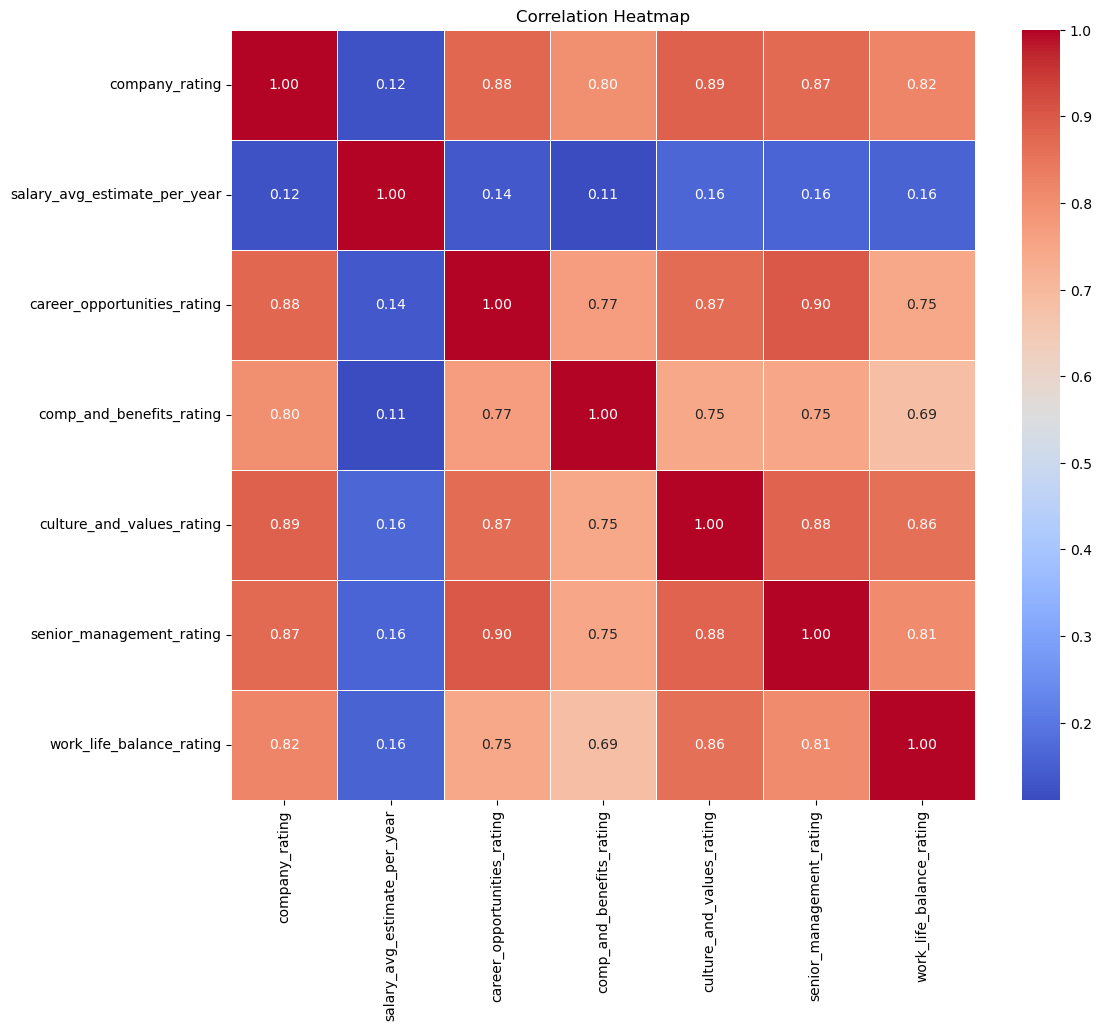

In [33]:
# Assuming your DataFrame is named 'df'
selected_columns = ['company_rating','salary_avg_estimate_per_year',
                    'company_size', 'company_founded','career_opportunities_rating',
'comp_and_benefits_rating',       
'culture_and_values_rating',      
'senior_management_rating',       
'work_life_balance_rating']

# Select the specified columns from the DataFrame
selected_data = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Model 1: Linear Regression

In [133]:
df = df.dropna(subset = 'company')

X = df[[
    'salary_estimate_payperiod',
 'company_founded',
 'career_opportunities_rating',
 'comp_and_benefits_rating',
 'culture_and_values_rating',
 'senior_management_rating',
 'company_size_1 to 50 Employees',
 'company_size_10000+ Employees',
 'company_size_1001 to 5000 Employees',
 'company_size_201 to 500 Employees',
 'company_size_5001 to 10000 Employees',
 'company_size_501 to 1000 Employees',
 'company_size_51 to 200 Employees',
 'company_size_Unknown',
 'revenue_$1 to $5 million (USD)',
 'revenue_$10+ billion (USD)',
 'revenue_$100 to $500 million (USD)',
 'revenue_$2 to $5 billion (USD)',
 'revenue_$25 to $50 million (USD)',
 'revenue_$5 to $10 billion (USD)',
 'revenue_$5 to $25 million (USD)',
 'revenue_$500 million to $1 billion (USD)',
 'revenue_Less than $1 million (USD)',
 'revenue_Unknown',
 'revenue_Unknown / Non-Applicable',
 'revenue_nan',
 'sector_Aerospace & Defence',
 'sector_Agriculture',
 'sector_Arts, Entertainment & Recreation',
 'sector_Construction, Repair & Maintenance Services',
 'sector_Education',
 'sector_Energy, Mining, Utilities',
 'sector_Finance',
 'sector_Healthcare',
 'sector_Hotel & Travel Accommodation',
 'sector_Human Resources & Staffing',
 'sector_Information Technology',
 'sector_Insurance',
 'sector_Legal',
 'sector_Management & Consulting',
 'sector_Manufacturing',
 'sector_Media & Communication',
 'sector_Non-profit & NGO',
 'sector_Pharmaceutical & Biotechnology',
 'sector_Real Estate',
 'sector_Retail & Wholesale',
 'sector_Telecommunications',
 'sector_Transportation & Logistics',
 'sector_Unknown',
 'sector_nan']]


y = df['company_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.251, random_state=1)

# # scaling to standardize values 
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)


# model = LinearRegression()


# model.fit(X_train_scaled,y_train)

# y_pred = model.predict(X_test_scaled)

# y_pred_val = model.predict(X_val_scaled)


# mse = mean_squared_error(y_test,y_pred)
# mse_2 = mean_squared_error(y_val,y_pred_val)
# mse

2.2706016728068426e+24

In [134]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM regressor
regressor = svm.SVR(kernel='rbf', gamma='scale')  # You can choose different kernels and parameters here

# Train the SVM regressor
regressor.fit(X_train_scaled, y_train)

# Predict target values for test set
y_pred = regressor.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.03399926997587075


/var/folders/n7/2mt83wy124sgy8t09zyv84sm0000gn/T/ipykernel_19396/377362045.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=3, color='red')  # Diagonal line for reference


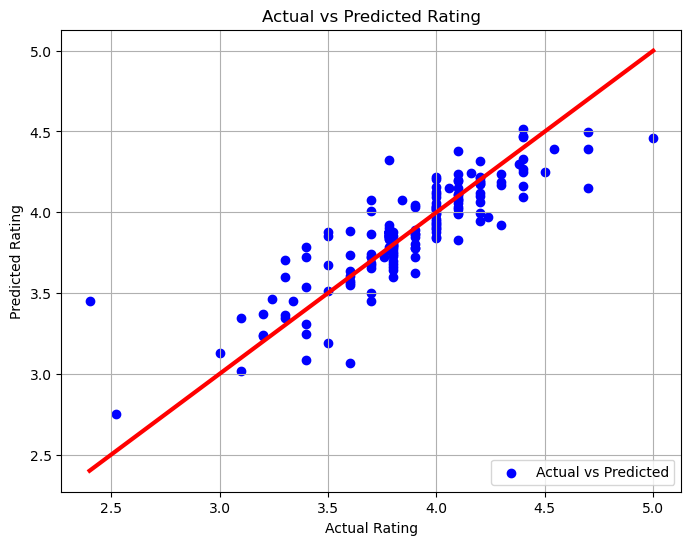

In [139]:
# Plotting the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=3, color='red')  # Diagonal line for reference
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Rating')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()